In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pickle

## Preprocess Elaad

In [2]:
rename_columns = {"TransactionId": "session",
                  "UTCTransactionStart": "starttime_parking",
                  "UTCTransactionStop": "endtime_parking",
                  "TotalEnergy": "total_energy",
                  "ConnectedTime": "connected_time",
                  "ChargeTime": "charged_time",
                  "MaxPower": "max_power",
                 }
df_elaad = pd.read_csv("../real_data/elaadnl_open_ev_datasets.csv", parse_dates = ["UTCTransactionStart", "UTCTransactionStop"])
df_elaad = df_elaad.rename(columns = rename_columns)

In [4]:
(df_elaad["total_energy"] / df_elaad["charged_time"]).describe()

count    10000.000000
mean         4.779556
std          2.808239
min          0.166667
25%          2.929529
50%          3.411765
75%          6.764667
max         15.472500
dtype: float64

In [5]:
#(pd.to_datetime(df_elaad["starttime_parking"].dt.date) - datetime.datetime(year = 2019, month = 1, day = 1)).dt.days

In [6]:
battery_capacity = 80
max_charging_speed = 11
FINAL_SOC = 0.97
ETA_C = 0.98 # Charging efficiency
df_elaad["start_hour"] = df_elaad["starttime_parking"].dt.hour
df_elaad["day_no"] = (pd.to_datetime(df_elaad["starttime_parking"].dt.date) - datetime.datetime(year = 2019, month = 1, day = 1)).dt.days
# Clean vehicles that have higher charged_time than connected time
df_elaad["charged_time"] = np.minimum(df_elaad["charged_time"], df_elaad["connected_time"])

df_elaad["energy_supplied"] = np.minimum(max_charging_speed * ETA_C * df_elaad["charged_time"], battery_capacity * FINAL_SOC)
df_elaad["initial_soc"] = (1 - df_elaad["energy_supplied"]/ (battery_capacity))
df_elaad["charged_time"] = np.ceil(df_elaad["charged_time"])
df_elaad["connected_time"] = np.ceil(df_elaad["connected_time"])
df_elaad["laxity"] = df_elaad["connected_time"] - (FINAL_SOC - df_elaad["initial_soc"]) * battery_capacity / (max_charging_speed*ETA_C)

# check
df_elaad["depart_time"] = np.minimum(df_elaad["start_hour"] + df_elaad["connected_time"], 23)
df_elaad["new_connected_time"] = df_elaad["depart_time"] - df_elaad["start_hour"]
df_elaad["new_laxity"] = df_elaad["new_connected_time"] - (FINAL_SOC - df_elaad["initial_soc"]) * battery_capacity / (max_charging_speed*ETA_C)

In [7]:
display(df_elaad[df_elaad["new_laxity"] >= -1000].describe(datetime_is_numeric = True))

,session,Connector,starttime_parking,endtime_parking,connected_time,charged_time,total_energy,max_power,start_hour,day_no,energy_supplied,initial_soc,laxity,depart_time,new_connected_time,new_laxity
count,1.000000e+04,10000.000000,10000,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.452817e+06,1.360300,2019-07-11 12:25:16.866000128,2019-07-11 18:14:39.090000128,6.328300,3.355300,13.635216,5.589366,12.412600,190.979600,28.608123,0.642398,3.897120,16.531700,4.119100,1.687920
min,3.261657e+06,1.000000,2019-01-01 00:30:00,2019-01-01 08:24:00,1.000000,1.000000,0.100000,0.167000,0.000000,0.000000,0.215600,0.030000,0.222635,2.000000,0.000000,-6.975881
25%,3.360979e+06,1.000000,2019-04-04 12:43:45,2019-04-04 16:33:00,2.000000,2.000000,4.530000,3.398000,9.000000,93.000000,13.475000,0.528375,0.752635,13.000000,2.000000,0.592635
50%,3.452182e+06,1.000000,2019-07-10 08:21:00,2019-07-10 13:31:30,4.000000,3.000000,7.830000,3.640000,12.000000,190.000000,24.147200,0.698160,1.182635,16.000000,3.000000,1.012635
75%,3.547667e+06,2.000000,2019-10-22 06:54:00,2019-10-22 13:03:00,9.000000,4.000000,18.262500,7.277750,16.000000,294.000000,37.730000,0.831562,5.024119,21.000000,6.000000,2.332635
max,3.634120e+06,2.000000,2019-12-31 21:22:00,2020-01-01 16:00:00,162.000000,26.000000,93.929000,22.500000,23.000000,364.000000,77.600000,0.997305,155.024119,23.000000,23.000000,18.702635
std,1.076139e+05,0.480111,NaN,NaN,7.093627,2.650125,14.282036,3.333663,4.532131,110.531348,20.586961,0.257337,6.334915,4.683011,2.858379,2.437884


In [507]:
df_elaad.to_csv("../real_data/df_elaad_preproc.csv", index = False)

Max occupancy:  20
Len occcupancy:  8776


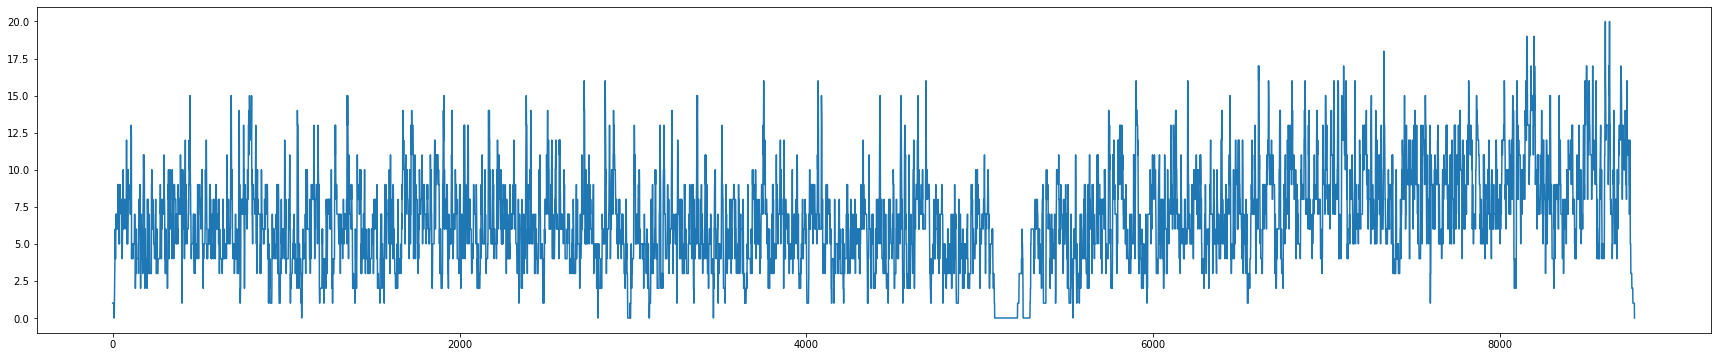

In [14]:
df_elaad_ts = df_elaad.copy()
starttime_min = pd.to_datetime("2019-01-01 00:00:00")
timestep = 60*60
df_elaad_ts["starttime_ts"] = np.floor((df_elaad_ts["starttime_parking"] - starttime_min).dt.total_seconds() / timestep)
df_elaad_ts["endtime_ts"] = np.floor((df_elaad_ts["endtime_parking"] - starttime_min).dt.total_seconds() / timestep)
hist_start, _ = np.histogram(df_elaad_ts["starttime_ts"], bins=list(range(int(df_elaad_ts["starttime_ts"].min()),
                                                                          int(df_elaad_ts["endtime_ts"].max()+1))))
hist_stop, _  = np.histogram(df_elaad_ts["endtime_ts"], bins=list(range(int(df_elaad_ts["starttime_ts"].min()),
                                                                        int(df_elaad_ts["endtime_ts"].max()+1))))
occupancy = (hist_start - hist_stop).cumsum()

fig1 = plt.figure(figsize=(30,6))
ax1 = fig1.add_subplot(1,1,1)
ax1.plot(list(range(len(occupancy))), occupancy)
print("Max occupancy: ", occupancy.max())
print("Len occcupancy: ", len(occupancy))

## Create EV dict

In [508]:
def load_result(result_loc):
    with open(result_loc, "rb") as infile:
        result = pickle.load(infile)
    return result


def create_ev_dict(seed):
    rng = np.random.default_rng(seed)

    FINAL_SOC = 0.97
    ALPHA_C = 11
    B_CAP = 80
    ETA_C = 0.98

    ev_dict = {}
    ev_outer_keys = ['init_soc','ev_stay_t','ev_laxity']

    for key in ev_outer_keys:
        ev_dict[key] = {}

    for key in ev_outer_keys:
        for h in range(24):
            ev_dict[key]['hour_{}'.format(str(h))] = []
                 
    for hour in range(24):
        num_arrived_ev = ev_data_sampler.sample_num_EV_arrivals(rng, hour)

        for _ in range(num_arrived_ev):
            stay_t = ev_data_sampler.sample_ev_stay_time(rng, hour)
            init_soc = ev_data_sampler.sample_init_soc(seed)
            seed += 1
            depart_time = hour + stay_t
            if(depart_time > 23):
                depart_time = 23
                stay_t = depart_time - hour
            laxity = stay_t - (FINAL_SOC - init_soc)*B_CAP/(ALPHA_C * ETA_C)
            if(laxity >= 0):
                ev_dict['ev_stay_t']['hour_{}'.format(hour)].append(stay_t)
                ev_dict['init_soc']['hour_{}'.format(hour)].append(init_soc)
                ev_dict['ev_laxity']['hour_{}'.format(hour)].append(laxity)
                
    return ev_dict

In [509]:
def create_ev_dict_from_df(df_ev, day): # day int: {0 - 364}
    FINAL_SOC = 0.97
    ALPHA_C = 11
    B_CAP = 80
    ETA_C = 0.98
    df_ev_day = df_ev[df_ev["day_no"] == day]
    
    # Init dict
    ev_dict = {}
    ev_outer_keys = ['init_soc','ev_stay_t','ev_laxity']
    for key in ev_outer_keys:
        ev_dict[key] = {}
        for h in range(24):
            ev_dict[key]["hour_{}".format(str(h))] = []

    for hour in range(24):
        df_ev_hour = df_ev_day[df_ev_day["start_hour"] == hour]    
        for _, row in df_ev_hour.iterrows():
            stay_t = row.new_connected_time
            init_soc = row.initial_soc
            depart_time = hour + stay_t
            
            if(depart_time > 23):
                depart_time = 23
                stay_t = depart_time - hour
            laxity =  stay_t - (FINAL_SOC - init_soc)*B_CAP/(ALPHA_C * ETA_C)
            if(laxity >= 0):
                ev_dict['ev_stay_t']['hour_{}'.format(hour)].append(stay_t)
                ev_dict['init_soc']['hour_{}'.format(hour)].append(init_soc)
                ev_dict['ev_laxity']['hour_{}'.format(hour)].append(laxity)              

    return ev_dict

In [515]:
df_ev = pd.read_csv("../real_data/df_elaad_preproc.csv", parse_dates = ["starttime_parking", "endtime_parking"])
print("Visits with negative laxity", len(df_ev[df_ev["new_laxity"] < 0]))
df_ev.describe()

Visits with negative laxity 751


,session,Connector,connected_time,charged_time,total_energy,max_power,start_hour,day_no,energy_supplied,initial_soc,laxity,depart_time,new_connected_time,new_laxity
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.452817e+06,1.360300,6.328300,3.355300,13.635216,5.589366,12.412600,190.979600,28.608123,0.642398,3.897120,16.531700,4.119100,1.687920
std,1.076139e+05,0.480111,7.093627,2.650125,14.282036,3.333663,4.532131,110.531348,20.586961,0.257337,6.334915,4.683011,2.858379,2.437884
min,3.261657e+06,1.000000,1.000000,1.000000,0.100000,0.167000,0.000000,0.000000,0.215600,0.030000,0.222635,2.000000,0.000000,-6.975881
25%,3.360979e+06,1.000000,2.000000,2.000000,4.530000,3.398000,9.000000,93.000000,13.475000,0.528375,0.752635,13.000000,2.000000,0.592635
50%,3.452182e+06,1.000000,4.000000,3.000000,7.830000,3.640000,12.000000,190.000000,24.147200,0.698160,1.182635,16.000000,3.000000,1.012635
75%,3.547667e+06,2.000000,9.000000,4.000000,18.262500,7.277750,16.000000,294.000000,37.730000,0.831562,5.024119,21.000000,6.000000,2.332635
max,3.634120e+06,2.000000,162.000000,26.000000,93.929000,22.500000,23.000000,364.000000,77.600000,0.997305,155.024119,23.000000,23.000000,18.702635


In [516]:
df_ev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   session             10000 non-null  int64         
 1   ChargePoint         10000 non-null  object        
 2   Connector           10000 non-null  int64         
 3   starttime_parking   10000 non-null  datetime64[ns]
 4   endtime_parking     10000 non-null  datetime64[ns]
 5   StartCard           10000 non-null  object        
 6   connected_time      10000 non-null  float64       
 7   charged_time        10000 non-null  float64       
 8   total_energy        10000 non-null  float64       
 9   max_power           10000 non-null  float64       
 10  start_hour          10000 non-null  int64         
 11  day_no              10000 non-null  int64         
 12  energy_supplied     10000 non-null  float64       
 13  initial_soc         10000 non-null  float64    

In [517]:
l_lax = []
flag_acc = 0
for day in range(365):
    ev_dict = create_ev_dict_from_df(df_ev, day)
print(ev_dict)

{'init_soc': {'hour_0': [], 'hour_1': [], 'hour_2': [], 'hour_3': [], 'hour_4': [], 'hour_5': [], 'hour_6': [0.8315625], 'hour_7': [0.6294375, 0.5809274999999999, 0.9461], 'hour_8': [], 'hour_9': [0.4933400000000001, 0.900285, 0.9083700000000001], 'hour_10': [0.382845, 0.7857475], 'hour_11': [0.5243325000000001, 0.479865], 'hour_12': [0.9043275, 0.030000000000000027, 0.9717024999999999, 0.522985, 0.8814200000000001, 0.5620625, 0.9299299999999999], 'hour_13': [0.88681], 'hour_14': [0.6779475, 0.7534075], 'hour_15': [], 'hour_16': [0.5310699999999999], 'hour_17': [0.6294375, 0.9582275], 'hour_18': [], 'hour_19': [], 'hour_20': [], 'hour_21': [0.7857475], 'hour_22': [], 'hour_23': []}, 'ev_stay_t': {'hour_0': [], 'hour_1': [], 'hour_2': [], 'hour_3': [], 'hour_4': [], 'hour_5': [], 'hour_6': [12.0], 'hour_7': [4.0, 4.0, 1.0], 'hour_8': [], 'hour_9': [4.0, 1.0, 1.0], 'hour_10': [6.0, 2.0], 'hour_11': [4.0, 4.0], 'hour_12': [2.0, 11.0, 1.0, 4.0, 1.0, 6.0, 1.0], 'hour_13': [1.0], 'hour_14': 

In [533]:
df_ev_laxp = df_ev[(df_ev["new_laxity"] >= 0)]
print(np.sum(df_ev_laxp["energy_supplied"] * 0.13))
print(np.sum(df_ev_laxp["energy_supplied"]))
df_ev_laxp.describe()

31186.083552
239892.9504


,session,Connector,connected_time,charged_time,total_energy,max_power,start_hour,day_no,energy_supplied,initial_soc,laxity,depart_time,new_connected_time,new_laxity
count,9.249000e+03,9249.000000,9249.000000,9249.000000,9249.000000,9249.000000,9249.000000,9249.000000,9249.000000,9249.000000,9249.000000,9249.000000,9249.000000,9249.000000
mean,3.451929e+06,1.363607,5.772516,3.021516,11.912129,5.517203,11.805601,190.135690,25.937177,0.675785,3.589104,16.006487,4.200887,2.017475
std,1.068298e+05,0.481063,6.798424,2.261761,12.344326,3.300258,4.131417,109.790022,18.359692,0.229496,6.169642,4.476385,2.917492,2.178919
min,3.261657e+06,1.000000,1.000000,1.000000,0.100000,0.328000,0.000000,0.000000,0.215600,0.030000,0.222635,2.000000,1.000000,0.002635
25%,3.361783e+06,1.000000,2.000000,2.000000,4.260000,3.361000,8.000000,94.000000,12.720400,0.566105,0.722635,13.000000,2.000000,0.702635
50%,3.451164e+06,1.000000,4.000000,3.000000,7.320000,3.604000,12.000000,189.000000,21.991200,0.725110,1.112635,16.000000,3.000000,1.062635
75%,3.545309e+06,2.000000,7.000000,4.000000,15.130000,7.200000,15.000000,291.000000,34.711600,0.840995,3.862635,20.000000,6.000000,2.562635
max,3.634120e+06,2.000000,162.000000,26.000000,93.181000,22.500000,22.000000,364.000000,77.600000,0.997305,155.024119,23.000000,23.000000,18.702635


In [534]:
connected_time = df_ev_laxp["new_connected_time"].to_numpy()
laxity = df_ev_laxp["new_laxity"].to_numpy()
np.corrcoef(connected_time, laxity)

array([[1.        , 0.81475901],
       [0.81475901, 1.        ]])

In [329]:
ev_dict_og = load_result('../w_mc_results/ev_dict')
print(ev_dict_og)
#df_ev = pd.read_csv()

{'init_soc': {'hour_0': [], 'hour_1': [], 'hour_2': [], 'hour_3': [], 'hour_4': [], 'hour_5': [], 'hour_6': [0.5095067975536738, 0.5803884477317867, 0.7002270252442875], 'hour_7': [0.6399993656286312], 'hour_8': [], 'hour_9': [], 'hour_10': [0.7278110604243994], 'hour_11': [0.30684996101452977, 0.49660778000133143], 'hour_12': [0.3584141438868519], 'hour_13': [0.6670284069483469, 0.7045546001043823], 'hour_14': [0.28745568140670547], 'hour_15': [0.5316484233965219, 0.4952519516335044], 'hour_16': [0.7175497556643715], 'hour_17': [], 'hour_18': [], 'hour_19': [0.49245405229860484], 'hour_20': [], 'hour_21': [], 'hour_22': [], 'hour_23': []}, 'ev_stay_t': {'hour_0': [], 'hour_1': [], 'hour_2': [], 'hour_3': [], 'hour_4': [], 'hour_5': [], 'hour_6': [4, 11, 9], 'hour_7': [3], 'hour_8': [], 'hour_9': [], 'hour_10': [7], 'hour_11': [7, 5], 'hour_12': [7], 'hour_13': [4, 5], 'hour_14': [9], 'hour_15': [8, 4], 'hour_16': [7], 'hour_17': [], 'hour_18': [], 'hour_19': [4], 'hour_20': [], 'hour_

## Create_forecast_ev_dict

In [330]:
def create_forecast_ev_dict(seed, sample_no): # DEAD CODE x_x in scheduler, but used for bids
    
    rng = np.random.default_rng(seed)
    ev_rng = np.random.default_rng(seed+sample_no)

    
    DAY_HRS = 24
    FINAL_SOC = 0.97
    ALPHA_C = 11
    B_CAP = 80
    ETA_C = 0.98
    NOISE_STD = 0.1

    ev_dict = {}
    ev_outer_keys = ['init_soc','ev_stay_t','ev_laxity']

    for key in ev_outer_keys:
        ev_dict[key] = {}

    for key in ev_outer_keys:
        for h in range(DAY_HRS):
            ev_dict[key]['hour_{}'.format(str(h))] = []
                 
    for hour in range(DAY_HRS):
        num_arrived_ev = ev_data_sampler.sample_num_EV_arrivals(rng, hour)
        
#         print('in forecast ', num_arrived_ev)
        
        num_arrived_ev_noise = ev_rng.normal(0, (num_arrived_ev*NOISE_STD))
        
        num_arrived_ev += num_arrived_ev_noise
#         if(num_arrived_ev_noise > 0):
#             num_arrived_ev = np.ceil(num_arrived_ev)
        num_arrived_ev = int(num_arrived_ev)
        
        if(num_arrived_ev <= 0):
            num_arrived_ev = 0
        
        for _ in range(num_arrived_ev):
            stay_t = ev_data_sampler.sample_ev_stay_time(rng, hour)
            stay_t_noise = ev_rng.normal(0, (stay_t*NOISE_STD))
            stay_t += stay_t_noise
            if(stay_t_noise > 0):
                stay_t = np.ceil(stay_t)
            stay_t = int(stay_t)

            
            if(stay_t >= (DAY_HRS-1)):
                stay_t = DAY_HRS-1
            elif(stay_t < 0):
                stay_t = 0
            
            init_soc = ev_data_sampler.sample_init_soc(seed)
            init_soc_noise = ev_rng.normal(0, (init_soc*NOISE_STD))
            init_soc += init_soc_noise
            seed += 1

            depart_time = hour + stay_t
            if(depart_time > 23):
                depart_time = 23
                stay_t = depart_time - hour
                
            if(init_soc >= FINAL_SOC):
                init_soc = FINAL_SOC
            elif(init_soc < 0):
                init_soc = 0
                                
            laxity = stay_t - (((FINAL_SOC - init_soc)*B_CAP)/(ALPHA_C * ETA_C))
            if(laxity >= 0):
                ev_dict['ev_stay_t']['hour_{}'.format(hour)].append(stay_t)
                ev_dict['init_soc']['hour_{}'.format(hour)].append(init_soc)
                ev_dict['ev_laxity']['hour_{}'.format(hour)].append(laxity)
                
    return ev_dict

We might get away by just using normal forecast_evs

In [335]:
df_ev.columns

Index(['session', 'ChargePoint', 'Connector', 'starttime_parking',
       'endtime_parking', 'StartCard', 'connected_time', 'charged_time',
       'total_energy', 'max_power', 'start_hour', 'day_no', 'energy_supplied',
       'initial_soc', 'laxity', 'depart_time', 'new_connected_time',
       'new_laxity'],
      dtype='object')

In [338]:
# Small stationarity check
df_ev["month_no"] = df_ev["starttime_parking"].dt.month
gdf_ev = df_ev.groupby(by = ["month_no"]).agg(avg_stay = ("new_connected_time", "mean"), avg_init_soc = ("initial_soc", "mean"), count = ("starttime_parking", "count")).reset_index()
gdf_ev.head(12)

,month_no,avg_stay,avg_init_soc,count
0,1,3.903265,0.652934,827
1,2,3.884000,0.648686,750
2,3,4.122399,0.644204,817
3,4,4.099765,0.663399,852
4,5,4.216041,0.664050,773
5,6,4.124832,0.667841,745
6,7,4.070442,0.667113,724
7,8,4.026455,0.653157,567
8,9,4.290323,0.639280,806
9,10,4.505208,0.626576,960


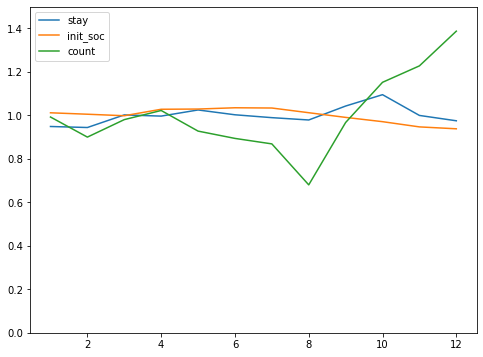

In [341]:
fig1 = plt.figure(figsize = (8,6))
ax1 = fig1.add_subplot(1,1,1)
y_stay = gdf_ev["avg_stay"] / gdf_ev["avg_stay"].mean()
y_init_soc = gdf_ev["avg_init_soc"] / gdf_ev["avg_init_soc"].mean()
y_count = gdf_ev["count"] / gdf_ev["count"].mean()
x = gdf_ev["month_no"]

ax1.plot(x, y_stay, label = "stay")
ax1.plot(x, y_init_soc, label = "init_soc")
ax1.plot(x, y_count, label="count")
ax1.set_ylim(0, 1.5)

ax1.legend()

In [342]:
# My eyeballs say: Maybe count is non stationary, but I wouldn't worry bout it. 

## Prices - Not useful

In [369]:
df_prices = pd.read_csv("../real_data/pv_prices_3yrs.csv",  parse_dates = ["date"])
display(df_prices.describe(datetime_is_numeric=True))
print(df_prices[(pd.to_datetime("2019-10-24 03:00:00") <= df_prices["date"]) & (df_prices["date"] < pd.to_datetime("2019-10-24 04:00:00"))]["price_imbalance"].mean())

,Unnamed: 0,date,price_da,price_imbalance
count,70369.00000,70369,70369.000000,70369.000000
mean,35186.03007,2020-02-15 21:16:27.660759552,55.062738,54.131856
min,0.00000,2018-10-01 00:00:00,-66.180000,-578.510000
25%,17593.00000,2019-04-02 06:30:00,38.080000,27.670000
50%,35185.00000,2019-10-01 18:30:00,48.350000,40.450000
75%,52779.00000,2021-04-01 17:30:00,65.000000,60.730000
max,70379.00000,2021-10-01 23:45:00,248.280000,999.000000
std,20316.04458,NaN,27.471054,76.782989


90.13


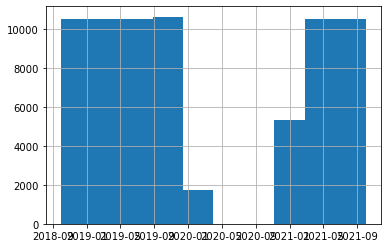

In [370]:
df_prices["date"].hist()

In [376]:
df_prices["Date"] = pd.to_datetime(df_prices["date"].dt.date)
df_prices["Hour"] = df_prices["date"].dt.hour
df_prices["price_da_thou"] = df_prices["price_da"] / 1000
df_prices["price_imbalance_thou"] = df_prices["price_imbalance"] / 1000
display(df_prices.head())
gdf_prices = df_prices.groupby(by = ["Date", "Hour"]).agg(price_da = ("price_da_thou", "mean"), price_imbalance = ("price_imbalance_thou", "mean")).reset_index()
df_price_2019 = gdf_prices[(pd.to_datetime("2019-01-01") <=gdf_prices["Date"]) & (gdf_prices["Date"] <= pd.to_datetime("2019-12-31"))].reset_index(drop = True)
df_price_2019.describe(datetime_is_numeric = True)

,Unnamed: 0,date,price_da,price_imbalance,Date,Hour,price_da_cent,price_imbalance_cent,price_da_thou,price_imbalance_thou
0,61537,2018-10-01 00:00:00,59.53,45.22,2018-10-01,0,0.5953,0.4522,0.05953,0.04522
1,61538,2018-10-01 00:15:00,59.53,53.48,2018-10-01,0,0.5953,0.5348,0.05953,0.05348
2,61539,2018-10-01 00:30:00,59.53,54.85,2018-10-01,0,0.5953,0.5485,0.05953,0.05485
3,61540,2018-10-01 00:45:00,59.53,53.54,2018-10-01,0,0.5953,0.5354,0.05953,0.05354
4,61541,2018-10-01 01:00:00,56.10,49.06,2018-10-01,1,0.5610,0.4906,0.05610,0.04906


,Date,Hour,price_da,price_imbalance
count,8759,8759.000000,8759.000000,8759.000000
mean,2019-07-02 00:15:17.364996096,11.501085,0.041198,0.041142
min,2019-01-01 00:00:00,0.000000,-0.009020,-0.148163
25%,2019-04-02 00:00:00,6.000000,0.034100,0.025491
50%,2019-07-02 00:00:00,12.000000,0.039700,0.032850
75%,2019-10-01 00:00:00,17.500000,0.047395,0.045951
max,2019-12-31 00:00:00,23.000000,0.121460,0.460695
std,NaN,6.922233,0.011278,0.034949


In [383]:
gdf_price_2019_day = df_price_2019.groupby(by = ["Date"]).agg(count = ("price_da", "count"))
gdf_price_2019_day[gdf_price_2019_day["count"] == 23].head()

,count
Date,
2019-03-31,23


In [384]:
df_price_2019[df_price_2019["Date"] == pd.to_datetime("2019-03-31")]

,Date,Hour,price_da,price_imbalance
2136,2019-03-31,0,0.04010,0.016035
2137,2019-03-31,1,0.03733,0.046870
2138,2019-03-31,3,0.04003,0.018260
2139,2019-03-31,4,0.03738,0.031625
2140,2019-03-31,5,0.03367,0.033823
2141,2019-03-31,6,0.03200,0.033168
2142,2019-03-31,7,0.03398,0.031685
2143,2019-03-31,8,0.03307,0.024935
2144,2019-03-31,9,0.03628,0.044628
2145,2019-03-31,10,0.03742,0.039430


## Save test and pv_data prices for 2019

In [497]:
sampling_price_df = pd.read_csv('../sampling_price_data.csv', index_col='Date')
sampling_price_df.index = pd.to_datetime(sampling_price_df.index)
display(sampling_price_df.head())


sampling_pv_gen_df = pd.read_csv('../sampling_pv_data.csv', index_col='Date')
sampling_pv_gen_df.index = pd.to_datetime(sampling_pv_gen_df.index)
display(sampling_pv_gen_df.head())

,price_da,price_imbalance,Hour
Date,,,
2018-01-01,0.02720,0.013963,0
2018-01-01,0.02730,0.033735,1
2018-01-01,0.03010,0.033675,2
2018-01-01,0.02087,0.042767,3
2018-01-01,0.02556,0.034423,4


,price_da,price_imbalance,Hour
count,32880.000000,32880.000000,32880.000000
mean,0.047930,0.047552,11.500000
std,0.024525,0.053456,6.922292
min,-0.079190,-0.414170,0.000000
25%,0.033867,0.023190,5.750000
50%,0.043890,0.037283,11.500000
75%,0.056570,0.059684,17.250000
max,0.248280,0.717250,23.000000


,PV_Vol,Hour
Date,,
2018-01-01,0.0,0
2018-01-01,0.0,1
2018-01-01,0.0,2
2018-01-01,0.0,3
2018-01-01,0.0,4


In [399]:
price_test_df_2019 = sampling_price_df[(pd.to_datetime("2019-01-01") <= sampling_price_df.index) & (sampling_price_df.index <= pd.to_datetime("2019-12-31"))]
pv_gen_test_df_2019 = sampling_pv_gen_df[(pd.to_datetime("2019-01-01") <= sampling_pv_gen_df.index) & (sampling_pv_gen_df.index <= pd.to_datetime("2019-12-31"))]

In [400]:
print("Price 2019", len(price_test_df_2019))
print("Pv gen 2019", len(pv_gen_test_df_2019))

Price 2019 8760
Pv gen 2019 8760


In [ ]:
#price_test_df = pd.read_csv('../new_data/new_test_data_price.csv', index_col='Date')
#pv_gen_test_df = pd.read_csv('new_data/new_test_data_pv.csv', index_col='Date')
price_test_df_2019.to_csv("../real_data/2019_test_data_price.csv")
pv_gen_test_df_2019.to_csv("../real_data/2019_test_data_pv.csv")

In [500]:
price_test_df_2019 = pd.read_csv("../real_data/2019_test_data_price.csv", index_col="Date")
price_test_df_2019.describe()

,price_da,price_imbalance,Hour
count,8760.000000,8760.000000,8760.000000
mean,0.041197,0.041140,11.500000
std,0.011278,0.034948,6.922582
min,-0.009020,-0.148163,0.000000
25%,0.034100,0.025489,5.750000
50%,0.039700,0.032848,11.500000
75%,0.047393,0.045947,17.250000
max,0.121460,0.460695,23.000000


In [490]:
x - 5//2

array([-2, -1,  0,  1,  2])

## Different distr

y_left=array([0.36, 0.28, 0.2 , 0.12, 0.04]), y_uniform=array([0.2, 0.2, 0.2, 0.2, 0.2]), y_right=array([0.04, 0.12, 0.2 , 0.28, 0.36])
np.sum(y_left)=1.0, np.sum(y_uniform)=1.0, np.sum(y_right)=1.0


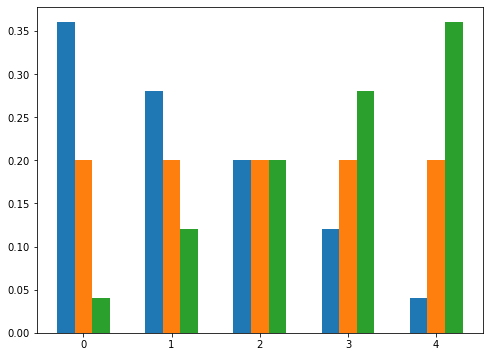

In [488]:
fig1 = plt.figure(figsize = (8,6))
ax1 = fig1.add_subplot(1,1,1)
x = np.array(list(range(5)))

slope = 0.08
y_left = np.multiply(x-2, -slope) + 0.2
y_uniform = np.multiply(x-2, 0) + 0.2
y_right = np.multiply(x-2,  slope) + 0.2
barwidth = 0.2
ax1.bar(x - 0.2, y_left, width = barwidth)
ax1.bar(x , y_uniform, width = barwidth)
ax1.bar(x + 0.2, y_right, width = barwidth)

print(f"{y_left=}, {y_uniform=}, {y_right=}")
print(f"{np.sum(y_left)=}, {np.sum(y_uniform)=}, {np.sum(y_right)=}")

In [480]:
print(np.random.choice([0.5, 0.75, 1, 1.25, 1.5], p = y_left))
print(np.random.choice([0.5, 0.75, 1, 1.25, 1.5], p = y_uniform))
print(np.random.choice([0.5, 0.75, 1, 1.25, 1.5], p = y_right))

1.25
0.75
1.5


In [484]:
np.ones(5) / len(x)

array([0.2, 0.2, 0.2, 0.2, 0.2])